---
title: "Adélie! Gentoo! Chinstrap!"
image: gentoo.jpg
format:
  html:
    toc: true
author: "Jeremy, Jun, Meichen"
date: "2022-03-10"
categories: [python, visualizations, ML]
---

## Overview

>An important task in the ecology of the Antarctic is to catalog the many different species of penguins in that area. Determining the species of a penguin often requires a combination of biological expertise and many precise measurements, which can be difficult to obtain.

>Because there are so many penguins, we can’t take many detailed measurements on all of them! In order to classify the species of penguins in large volume, we need to figure out *which* measurements are most important for distinguishing penguin species.

>**In this post, our objective is to determine a small set of measurements that are highly predictive of a penguin’s species.** In particular, we will perform feature selection and then use a variety of machine learning models to determine the "best" set of three distinct measurements. 

<br>

## 1. Data Import and Cleaning

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

penguins = pd.read_csv("palmer_penguins.csv")
#penguins.head()

# split data into training and test
from sklearn.model_selection import train_test_split

np.random.seed(111)
train, test = train_test_split(penguins, test_size = 0.2)

# clean the split data, define a function first
from sklearn import preprocessing
def prep_penguins_data(data_df):
    df = data_df.copy()
    le = preprocessing.LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    df = df.drop(['Comments'], axis = 1)
    df = df.drop(['studyName'], axis = 1)
    # simply the species name
    df["Species"] = df["Species"].str.split().str.get(0)
    # drop the NaN values
    df = df.dropna()
    
    X = df.drop(['Species'], axis = 1)
    y = df['Species']
        
    return(X, y)

X_train, y_train = prep_penguins_data(train)
X_test,  y_test  = prep_penguins_data(test)

X_train.head()
#y_test.head()

,Sample Number,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
281,62,Anvers,Biscoe,"Adult, 1 Egg Stage",N18A2,Yes,11/3/08,46.2,14.9,221.0,5300.0,2,8.60092,-26.84374
329,110,Anvers,Biscoe,"Adult, 1 Egg Stage",N29A2,Yes,11/9/09,48.1,15.1,209.0,5500.0,2,8.45738,-26.22664
147,148,Anvers,Dream,"Adult, 1 Egg Stage",N83A2,Yes,11/13/09,36.6,18.4,184.0,3475.0,1,8.68744,-25.83060
318,99,Anvers,Biscoe,"Adult, 1 Egg Stage",N21A1,Yes,11/18/09,48.4,14.4,203.0,4625.0,1,8.16582,-26.13971
38,39,Anvers,Dream,"Adult, 1 Egg Stage",N25A1,No,11/13/07,37.6,19.3,181.0,3300.0,1,9.41131,-25.04169


<br>

## 2. Exploratory Analysis

### Table 1: Summary Table

In [2]:
# summary table

# simplify species column first

penguins["Species"] = penguins["Species"].str.split().str.get(0)

def penguin_summary_table(group_cols,value_cols):
    summary = penguins.groupby(group_cols)[value_cols].aggregate(np.mean).round(2)
    return summary

penguin_summary_table(["Island","Species"], 
                      ["Flipper Length (mm)", "Body Mass (g)", "Culmen Depth (mm)",
                       "Culmen Length (mm)","Delta 15 N (o/oo)"])


Flipper Length (mm)  Body Mass (g)  Culmen Depth (mm)  \
Island    Species                                                            
Biscoe    Adelie                  188.80        3709.66              18.37   
          Gentoo                  217.19        5076.02              14.98   
Dream     Adelie                  189.73        3688.39              18.25   
          Chinstrap               195.82        3733.09              18.42   
Torgersen Adelie                  191.20        3706.37              18.43   

                     Culmen Length (mm)  Delta 15 N (o/oo)  
Island    Species                                           
Biscoe    Adelie                  38.98               8.82  
          Gentoo                  47.50               8.25  
Dream     Adelie                  38.50               8.95  
          Chinstrap               48.83               9.36  
Torgersen Adelie                  38.95               8.79

In [3]:
# first create a function to create scatterplots by island
# (will make three separate scatterplots, one for each island)

# used for figures 1 and 2

def island_plotter(df, x_label, y_label,ax_num):
    """
    This function can only be used on our penguins dataframe
    because it references the "Species" column by name.
    """
    
    # initialize three plots, one for each island
    fig, ax = plt.subplots(1,3,figsize = (20,5),sharey = True, sharex = True)
    # set y label first
    ax[0].set(ylabel = y_label)
    
    species_set = set(penguins["Species"])
    island_set = set(penguins["Island"])

    for i in range(3):
        # set x label first
        ax[i].set(xlabel = x_label)
        ax[i].set(title = ax_num[i]) 
    
        island_mask = penguins["Island"] == ax_num[i]
        current = penguins[island_mask]
        
        for species in species_set:
            # plot points for each species 
            current_new = current[current["Species"] == species]
            ax[i].scatter(current_new[x_label],current_new[y_label],
                           label = species, alpha = 0.5)
        ax[i].legend()
        
    return fig


### Figure 1

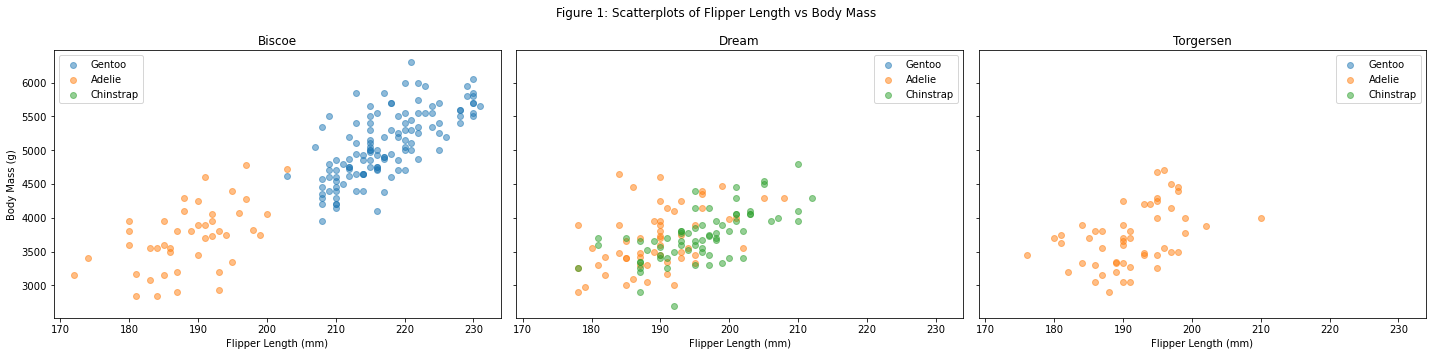

In [4]:
# Figure 1 : scatterplot of species + island vs flipper length

ax_num = {
    0: "Biscoe",
    1: "Dream",
    2: "Torgersen"
}

fig1 = island_plotter(penguins, "Flipper Length (mm)", "Body Mass (g)",ax_num)
fig1.suptitle("Figure 1: Scatterplots of Flipper Length vs Body Mass")

# make everything less squished
fig1.tight_layout()


Figure 1 explanation:

Figure 1 is a scatterplot of flipper length (mm) vs body mass (g) of each penguin species on each island. We decided to plot these two quantitative variables because we noticed notable differences between variable means for each species (from the summary table).

There seems to be a positive correlation between flipper length and body mass, as well as correlation between penguin size and penguin species. The longer the flipper length the larger the body mass. Additionally, Chinstrap penguins may be slightly larger than Adelie penguins, but the most notable trend is that Gentoo penguins are by far the largest of the three species (Gentoo penguins have the largest flipper length and body mass).


### Figure 2

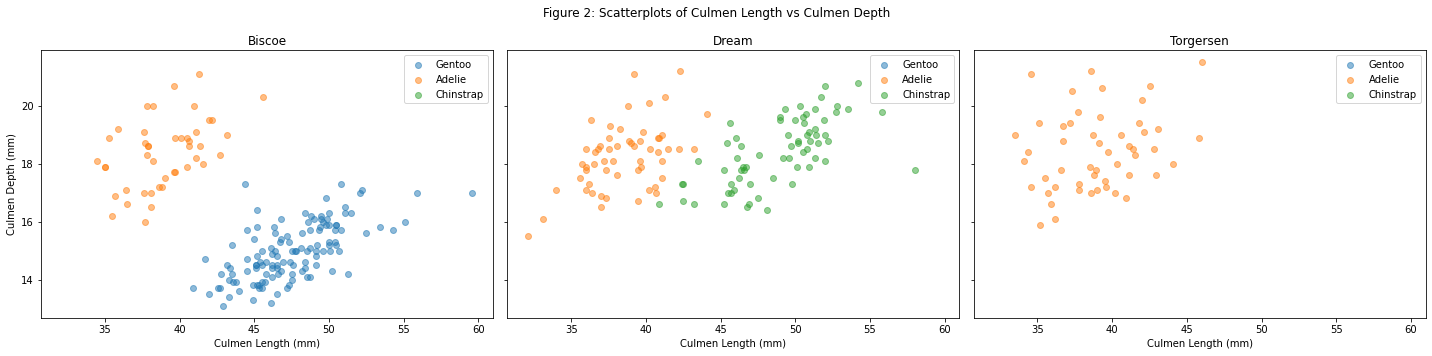

In [5]:
# Figure 2 : scatterplots of culmen length and culmen depth by species by island

fig_b = island_plotter(penguins, "Culmen Length (mm)", "Culmen Depth (mm)", ax_num)
fig_b.suptitle("Figure 2: Scatterplots of Culmen Length vs Culmen Depth")
fig_b.tight_layout()

Figure 2 explanation: 

We chose culmen length and depth as our variables because we wanted to see if a longer or deeper beak would serve as a predictor of the species of penguin. The results show that Adelie penguins tend to have shorter and deeper culmens, Gentoo penguins have longer but shallower culmens, and Chinstrap penguins have about equal length of culmens as Gentoos and about equal depth as Adelies.

### Figure 3

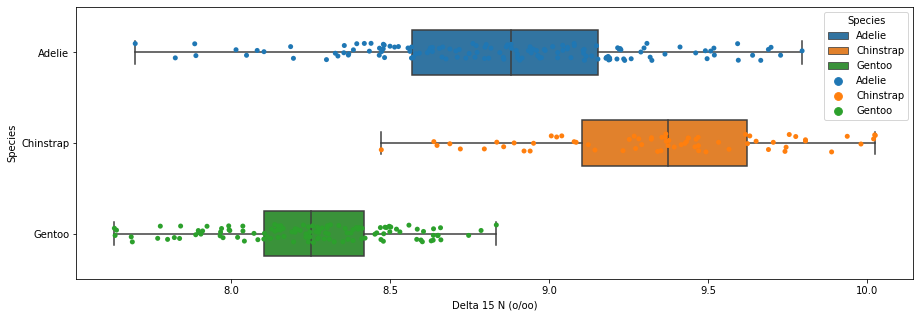

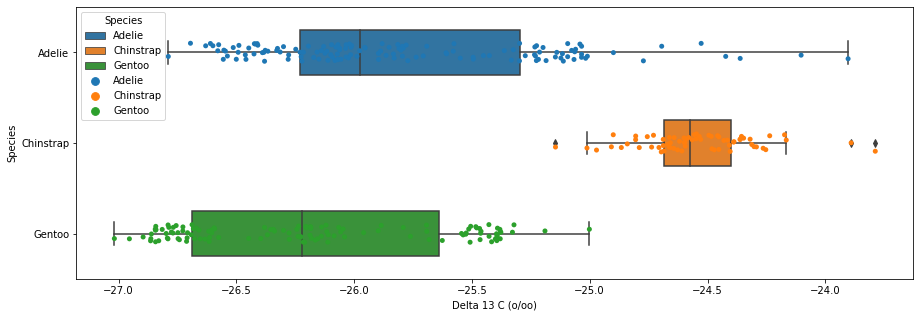

In [6]:
# figure 3 : boxplots of Delta 15 N and Delta 13 C by species

import seaborn as sns
fig,ax = plt.subplots(1, figsize = (15,5))
fig = sns.boxplot(data = penguins, x="Delta 15 N (o/oo)",y="Species", hue = "Species", dodge = False, width=0.5)
fig = sns.stripplot(data = penguins, x="Delta 15 N (o/oo)", y="Species", hue = "Species")
fig2,ax = plt.subplots(1, figsize = (15,5))
fig2 = sns.boxplot(data = penguins, x="Delta 13 C (o/oo)", y="Species", hue = "Species", dodge = False, width=0.5)
fig2 = sns.stripplot(data = penguins, x="Delta 13 C (o/oo)", y="Species", hue = "Species")


Figure 3 explanation: 

We decided to use Delta 15 N (o/oo) as our quantitative feature in this figure because after looking at the table, there seems to be a clear distinction across different species. For example, under this category, the Gentoo penguins, by far, have the least amount of nitrogen isotopes in their blood, while the Chinstrap possess the most. Having a clear distinction across species would better inform our modeling because there is less room for error and the model can better predict based on less ambiguous decision regions.

### Figure 4

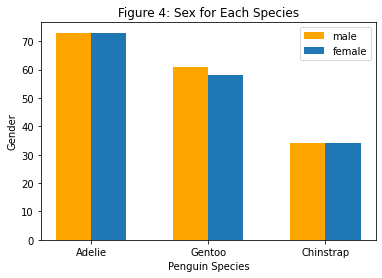

In [7]:
# figure 4: scatterplot of culmen depth vs length for each species by island

# ignore SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

def getSex(df, secks):
    '''
    returns the number of the desired gender
    that existed in the given dataframe
    
    parameter df: the dataframe we're parsing
    parameter secks: the sex we're isolating 
    within the data
    '''
    sexMask = df["Sex"] == secks
    sex = df[sexMask] # only keep the desired sex
    return len(sex["Sex"])

fig, ax = plt.subplots(1) # creates plot
cols = ["Species", "Sex"] # isolates only the species and the sex
peng = penguins[cols]

recode = { # recode the sexes to 0s and 1s, .s to nan
    "MALE": 0,
    "FEMALE": 1,
    ".": np.nan
}

peng["Sex"] = peng["Sex"].map(recode) # recodes sexes

nans = peng["Sex"].isna()    # rounds up the nans
peng = peng[np.invert(nans)] # takes out the nans

peng["Species"] = peng["Species"].str.split().str.get(0) # isolates first word of species

adMask = peng["Species"] == "Adelie"      # masks all the adelie penguins
genMask = peng["Species"] == "Gentoo"     # masks all the gentoo penguins
chinMask = peng["Species"] == "Chinstrap" # masks all the chinstrap penguins

adelie = peng[adMask]
gentoo = peng[genMask]
chinstrap = peng[chinMask] # isolates each species and its sex

adelMale = getSex(adelie, 0) # gets the number of each sex for each species
gentMale = getSex(gentoo, 0)
chinMale = getSex(chinstrap, 0)
adelFemale = getSex(adelie, 1)
gentFemale = getSex(gentoo, 1)
chinFemale = getSex(chinstrap, 1)

male = [adelMale, gentMale, chinMale] # makes a list of each sex for the graph
female = [adelFemale, gentFemale, chinFemale]

bar = np.arange(3) # 3 species -> 3 sections on the bar graph
width = 0.3        # width of the bars

ax.bar(x = bar, width = width, height = male, color = "orange", label = "male") # plots males
ax.bar(x = bar + width, width = width, height = female, label = "female")       # plots females
ax.set(xlabel = "Penguin Species", ylabel = "Gender", title = "Figure 4: Sex for Each Species")
plt.xticks(bar + width / 2, ("Adelie", "Gentoo", "Chinstrap")) # sets labels for each section
ax.legend()

Figure 4 explanation:

We chose sex and penguin species because for the qualitative variable, we wanted to see if sex would be able to predict the type of species. The results show that there is virtually no difference in the levels of male and female penguins for all three species, which is most likely attributed to the fact that the scientists wanted to record equal numbers of each species, as to avoid any biases in the data. However, the graph does show us that Adelie penguins make up the majority of the penguins. Gentoo penguins have the second highest number of penguins, and Chinstrap penguins have the fewest.

<br>

## 3. Feature Selection

In [8]:
# make combos of three groups of features based on our 
# exploratory data analysis


combos = [["Island", "Flipper Length (mm)", "Body Mass (g)"],
          ["Island", "Culmen Length (mm)", "Culmen Depth (mm)"],
          ["Island", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"],
          ["Island", "Flipper Length (mm)", "Culmen Length (mm)"],
          ["Island", "Flipper Length (mm)", "Culmen Depth (mm)"],
          ["Island", "Culmen Depth (mm)", "Body Mass (g)"],
          ["Island", "Culmen Length (mm)", "Body Mass (g)"], 
          ["Island", "Culmen Depth (mm)", "Delta 13 C (o/oo)"], 
          ["Island", "Culmen Length (mm)", "Delta 13 C (o/oo)"], 
          ["Island", "Flipper Length (mm)", "Delta 13 C (o/oo)"], 
          ["Island", "Body Mass (g)", "Delta 13 C (o/oo)"],
          ["Island", "Culmen Depth (mm)", "Delta 15 N (o/oo)"], 
          ["Island", "Culmen Length (mm)", "Delta 15 N (o/oo)"], 
          ["Island", "Flipper Length (mm)", "Delta 15 N (o/oo)"],
          ["Island", "Body Mass (g)", "Delta 15 N (o/oo)"],]


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
 
LR=LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=1000)

X_trainCombo = X_train.copy()
X_trainCombo.replace(("Dream", "Torgersen","Biscoe"), (0,1,2), inplace = True)

combs = []
scores = []

def check_column_score(cols):
    """
    Trains and evaluates a model via cross validation on the columns of the data 
    with selected indeces
    """
    
    #print("training with columns" + str(cols))
    combs.append(str(cols))
    return cross_val_score(LR,X_trainCombo[cols],y_train,cv=5).mean()

for combo in combos:
    x=check_column_score(combo)
    scores.append(x)
    #print("CV score is "+ str(np.round(x,3)))
    
totals = []
for ind in range(len(combs)):
    totals.append(tuple((scores[ind], combs[ind])))

totals.sort(reverse = True)

for eachScore in totals:
    print(eachScore)

(0.9850454227812719, "['Island', 'Culmen Length (mm)', 'Culmen Depth (mm)']")
(0.9664570230607966, "['Island', 'Culmen Length (mm)', 'Delta 15 N (o/oo)']")
(0.962753319357093, "['Island', 'Flipper Length (mm)', 'Delta 13 C (o/oo)']")
(0.9626135569531795, "['Island', 'Culmen Length (mm)', 'Body Mass (g)']")
(0.958909853249476, "['Island', 'Culmen Length (mm)', 'Delta 13 C (o/oo)']")
(0.9552760307477289, "['Island', 'Flipper Length (mm)', 'Culmen Length (mm)']")
(0.9365478686233404, "['Island', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)']")
(0.8914744933612859, "['Island', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']")
(0.8842767295597485, "['Island', 'Flipper Length (mm)', 'Delta 15 N (o/oo)']")
(0.884136967155835, "['Island', 'Flipper Length (mm)', 'Culmen Depth (mm)']")
(0.8545073375262054, "['Island', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)']")
(0.8206848357791754, "['Island', 'Body Mass (g)', 'Delta 13 C (o/oo)']")
(0.8132075471698114, "['Island', 'Culmen Depth (mm)', 'Body Mass (g)']")
(

The CV scores indicate that models using the combinations of (Island, Culmen Length, and Culmen Depth), (Island, Culmen Length, and Delta 15 N), and (Island, Flipper Length, and Delta 13 C) are the best predictors of penguin species for the unseen test data. The culmen length and depth set scored remarkably high (0.985, with 1 being a perfect predictor of the data), which may be the product of overfitting, so more exploration is needed there. Culmen length and nitrogen levels in the bloodstream and flipper length and carbon levels in the bloodstream were also very high, clocking in CV scores of 0.966 and 0.962, respectively. These could also be attributed to overfitting, but the models below will better indicate whether or not that is the case. 

Overall, the CV scores for all of our combination permutations were pretty high, with the lowest score being 0.795. This suggests that the variables we selected are all generally good performers at predicting the species for the unseen data.

<br>

## 4. Modeling

In [9]:
# funtions used throughout all the models

# confusion matrix analysis
from sklearn.metrics import confusion_matrix
def confusion_matrix_func(model, X_train_model, X_test_model, y_train, y_test):
    """
    returns the confusion matrix evaluated only on the test data, not the training data
    
    input parameters: 
        model (the type of model used), 
        X_train_model (training data that only has the selected features),
        X_test_model (test data that only has the selected features)
        y_train (training data with target variable),
        y_test (testing data with target variable)
        
    output: 
        c (a 3x3 confusion matrix)
    """
    
    model.fit(X_train_model, y_train) 
    y_test_pred = model.predict(X_test_model) 
    c = confusion_matrix(y_test,y_test_pred) 
    #create a mask to see where the predictions do not align with the data
    mask = y_test != y_test_pred 
    mistakes = X_test_model[mask]
    mistake_labels = y_test[mask]
    mistake_preds = y_test_pred[mask]
    #these are the errors in the model
    print("The mislabels in the model are: " + str(mistake_preds))
    #these are the actual data points
    print("The correct species for these penguins are: " + "\n" + str([mistake_labels])) 
    return c

#dictionary for islands
ax_num = {
    0: "Biscoe",
    1: "Dream",
    2: "Torgersen"
}

def plot_regions(c, X, y, ax_num, x_label, y_label): 
    """
    This function trains a model on the provided data
    and outputs a decision region plot. Since our qualitative 
    predictor is Islands for our project, this function
    returns 3 subplots (one for each island).
    
    input parameters:
        c (model you are fitting),
        X (training data that only has the selected features),
        y (training data with target variable),
        ax_num (dictionary of islands used to create subplots),
        x_label (feature shown on x axis),
        y_label (feature shown on y axis)
        
    output:
        decision region plot 
    """
    # train single model on all penguin data
    # REPLACE WITH YOUR MODEL 
    c.fit(X, y)

    x0=X[x_label]
    x1=X[y_label]
    
    grid_x=np.linspace(x0.min(),x0.max(),501) 
    grid_y=np.linspace(x1.min(),x1.max(),501) 
    
    xx,yy=np.meshgrid(grid_x,grid_y)
    np.shape(xx),np.shape(yy)

    # reshaping into 1 D array 
    XX=xx.ravel()
    YY=yy.ravel()
    np.shape(XX)  

    # make three separate predictions (one for each island)
    # islands are currently encoded as 3,4,5

    fig,ax=plt.subplots(1,3,figsize = (20,5))
    for i in ax_num:
    
        ZZ = np.ones(251001) * (i+3)
        # predict assuming all points are from current island
        result = c.predict(np.c_[ZZ,XX,YY])
        result = result.reshape(xx.shape)

        #plot the decision region for subplot 
        ax[i].contourf(xx,yy,result,cmap = "jet",alpha=.2)
        
        # set axis labels for subplot
        ax[i].set(xlabel=x_label,
              ylabel=y_label,
             title = ax_num.get(i))
        
        # prep actual data to be plotted
        # on subplot (as scatterplot)
        mask = X["Island"] == i+3
        island_x0 = x0[mask]
        island_x1 = x1[mask]
        species_set = set(y)
        
        # plot actual data points
        colors = np.array(["blue", "green","red"])
        for species in species_set: 
            s_mask = y == species
            ax[i].scatter(island_x0[s_mask],island_x1[s_mask],label = species, 
                          c = colors[species],alpha = 1)
 
        # add legend to each subplot
        L=ax[i].legend()
        L.get_texts()[0].set_text('Adelie')
        L.get_texts()[1].set_text('Chinstrap')
        L.get_texts()[2].set_text('Gentoo')

    

### Model 1 : K Nearest Neighbors

#### 1. Cross validation to choose complexity parameters

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
pd.options.mode.chained_assignment = None 

# prep training data to feed into model 

# prep X_train data by only selecting the three variables 
# we are using for this model, 
# then recodeing the islands as numeric (3,4,5).
# chose these numbers arbitrarily since we used (0,1,2)
# to recode the islands. 
# final dataframe used is X_train_knn
X_train_knn = X_train.copy()
X_train_knn = X_train_knn[["Island","Flipper Length (mm)","Delta 13 C (o/oo)"]]
X_train_knn.replace(("Biscoe", "Dream","Torgersen"), (3,4,5), inplace= True)

# prep y_train data be recoding islands as numeric (0,1,2)
# final data used is y_train_knn
y_train_knn = y_train.copy()
y_train_knn.replace(("Adelie", "Chinstrap","Gentoo"), (0,1,2), inplace= True)


# cross validation to find best number of nearest neighbors
# to use

nn_pool= [2,3,4,5,6,7,8,9,10]
best_score=-np.inf

for n in nn_pool:
    knn= KNeighborsClassifier(n_neighbors=n)
    score=cross_val_score(knn,X_train_knn,y_train_knn,cv=5).mean()
    if score>best_score:
        best_score=score
        best_n=n
    print("N=",n," Cross validation score=",score)
print(best_n)

N= 2  Cross validation score= 0.9031446540880503
N= 3  Cross validation score= 0.8956673654786863
N= 4  Cross validation score= 0.9105520614954576
N= 5  Cross validation score= 0.8955974842767296
N= 6  Cross validation score= 0.8844164919636619
N= 7  Cross validation score= 0.873235499650594
N= 8  Cross validation score= 0.8658280922431866
N= 9  Cross validation score= 0.8695317959468902
N= 10  Cross validation score= 0.8695317959468902
4


#### 2. Evaluation on unseen testing data

In [11]:
# fit model with parameter chosen from cross validation
KNN = KNeighborsClassifier(n_neighbors = best_n)
KNN.fit(X_train_knn,y_train_knn)

# prep unseen test data 
X_test_knn = X_test.copy()
X_test_knn = X_test[["Island","Flipper Length (mm)","Delta 13 C (o/oo)"]]
X_test_knn.replace(("Biscoe", "Dream","Torgersen"), (3,4,5), inplace= True)
y_test_knn = y_test.copy()
y_test_knn.replace(("Adelie", "Chinstrap","Gentoo"), (0,1,2), inplace= True)
print("Final accuracy score on unseen test data is " + 
      str(KNN.score(X_test_knn,y_test_knn)))

# examine results with confusion matrix
confusion_matrix_func(KNN,X_train_knn, X_test_knn,y_train, y_test)

Final accuracy score on unseen test data is 0.9193548387096774
The mislabels in the model are: ['Adelie' 'Adelie' 'Adelie' 'Chinstrap' 'Adelie']
The correct species for these penguins are: 
[153    Chinstrap
198    Chinstrap
195    Chinstrap
45        Adelie
204    Chinstrap
Name: Species, dtype: object]


array([[24,  1,  0],
       [ 4,  9,  0],
       [ 0,  0, 24]])

#### 3. Visualization of decision regions

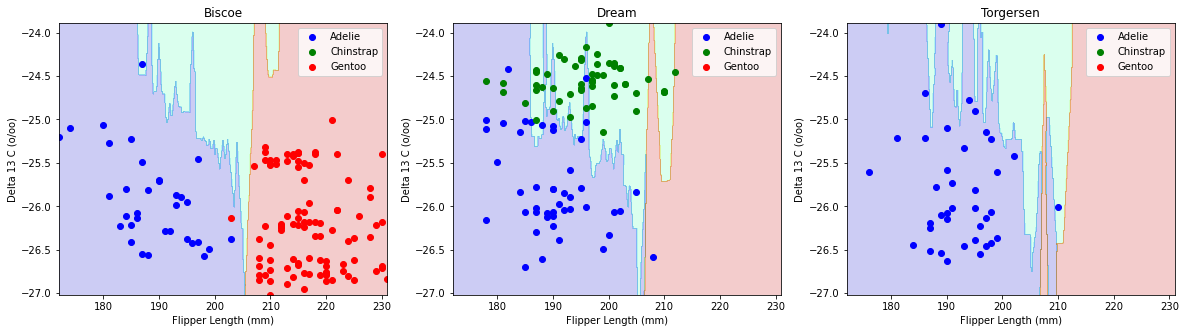

In [12]:
plot_regions(KNN, X_train_knn, y_train_knn, ax_num,"Flipper Length (mm)","Delta 13 C (o/oo)")

#### 4. Discussion for K nearest neighbors

Out of unseen testing data, the model incorrectly labels four Chinstrap penguins as Adelie penguins, and one Adelie penguin as a Chinstrap penguin. This is understandable as the decision regions plot for the island Dream shows the most inconsistencies between the fitted Knn model and the training data, and Dream only has Chinstrap and Adelie penguins. 

On the Dream plot, the largest inconsistency is the 7 green data points (representing Chinstrap) in the region the fitted model marked blue (representing Adelie), which indicates the fitted model has a tendency to mislabel Chinstrap penguins as Adelie penguins. There are also a couple blue points in or on the border of the green region, which explains why the model may have mislabeled one Adelie penguin as Chinstrap. 

### Model 2 :  Random Forests

#### 1. Cross validation to choose complexity parameters

In [13]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix
#pd.options.mode.chained_assignment = None

#further clean the data so we only have our selected features
X_train_RF = X_train.copy()
X_train_RF = X_train_RF[["Island", "Culmen Length (mm)", "Delta 15 N (o/oo)"]]
X_train_RF.replace(("Biscoe","Dream","Torgersen"), (3,4,5), inplace=True)
X_test_RF = X_test.copy()
X_test_RF = X_test[["Island", "Culmen Length (mm)", "Delta 15 N (o/oo)"]]
X_test_RF.replace(("Biscoe","Dream","Torgersen"), (3,4,5), inplace=True)

N=50
scores = np.zeros(N)
best_score = -np.inf

#use cross-validation to pick our complexity parameters (n_estimators)
for d in range(1,N+1):
    rf = RandomForestClassifier(n_estimators = d)
    scores[d-1]=cross_val_score(rf,X_train_RF,y_train,cv=5).mean()
    if scores[d-1]>best_score:
        best_score=scores[d-1]
        best_depth=d
    #print("D=",d," Cross validation score=",score)
print("Best depth = ", best_depth)

Best depth =  12


#### 2. Evaluation on unseen testing data

In [14]:
#use the best_depth from above to model
RF = RandomForestClassifier(n_estimators = best_depth) 
RF.fit(X_train_RF,y_train) #fit our data
#evaluate our accuracy on the testing data
print("The accuracy of this model on the testing data is " + str(RF.score(X_test_RF,y_test))) 

# examine results with confusion matrix
confusion_matrix_func(RF,X_train_RF, X_test_RF,y_train, y_test)


The accuracy of this model on the testing data is 0.967741935483871
The mislabels in the model are: ['Adelie' 'Gentoo']
The correct species for these penguins are: 
[182    Chinstrap
111       Adelie
Name: Species, dtype: object]


array([[24,  0,  1],
       [ 1, 12,  0],
       [ 0,  0, 24]])

#### 3. Visualization of decision regions

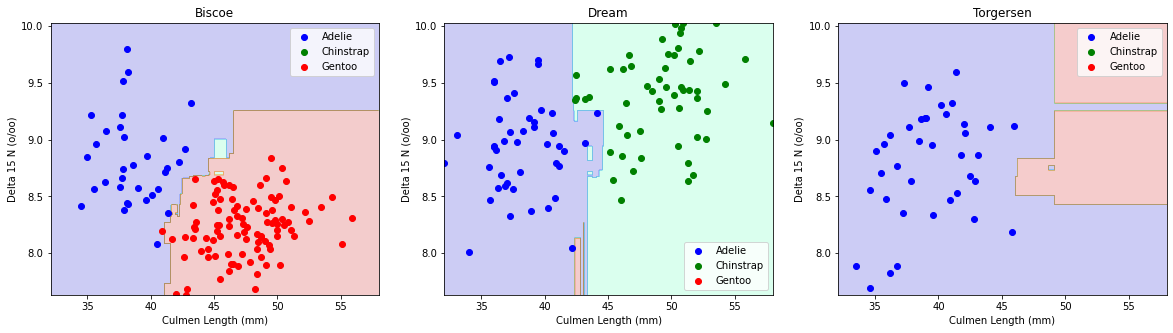

In [15]:
y_train_RF = y_train.copy()
y_train_RF.replace(("Adelie", "Chinstrap","Gentoo"), (0,1,2), inplace=True)
plot_regions(RF, X_train_RF, y_train_RF, ax_num,"Culmen Length (mm)","Delta 15 N (o/oo)")

#### 4.  Discussion for random forests

 Based on the decision regions above, only one of the data points seems to be in the wrong "region", yielding a high accuracy percentage of 95%. Due to the nature of random forests, the regions have more detailed boundaries (as opposed to just being a rectangular box), meaning that there are still going to be a couple of points that reside around these boundaries that the model will mislabel. For example, a blue data point in the island "Dream" plot that near the border of the two decision regions is found to be our mislabel according to our confusion matrix. Another mislabel can be found in the "Biscoe" plot with one of the red points that crosses the border into the blue region (this is the data point that was described at the beginning). Again, these mislabels occur because these points are located so close to the fine-tuned borders created by the random forests.

### Model 3: Multinomial Logistic Regression

#### 1. Cross validation to choose complexity parameters

cv = 29: 0.9776380153738644
cv = 28: 0.9776380153738644
cv = 11: 0.9775681341719078
cv = 10: 0.9775681341719078
cv = 9: 0.9775681341719078
cv = 8: 0.9775681341719078
cv = 7: 0.9775681341719078
cv = 3: 0.9775681341719078
cv = 2: 0.9775681341719078
cv = 1: 0.9775681341719078
cv = 0: 0.9775681341719078
cv = 27: 0.973864430468204
cv = 26: 0.973864430468204
cv = 25: 0.973864430468204
cv = 24: 0.973864430468204
cv = 23: 0.973864430468204
cv = 22: 0.973864430468204
cv = 21: 0.973864430468204
cv = 20: 0.973864430468204
cv = 19: 0.973864430468204
cv = 18: 0.973864430468204
cv = 17: 0.973864430468204
cv = 16: 0.973864430468204
cv = 15: 0.973864430468204
cv = 14: 0.973864430468204
cv = 13: 0.973864430468204
cv = 12: 0.973864430468204
cv = 6: 0.973864430468204
cv = 5: 0.973864430468204
cv = 4: 0.973864430468204
best C value: 29


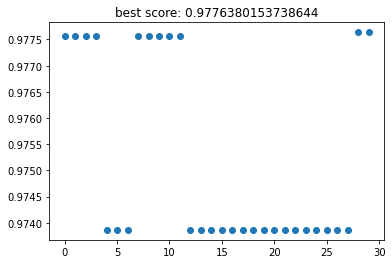

In [16]:
from sklearn.linear_model import LogisticRegression

n = 30
scores = np.zeros(n)
bestScore = -np.inf # neg infinity so that first score in loop will be the new best score
bestC = 1

X_trainLR = X_train.copy()
X_trainLR = X_trainLR[["Island", "Culmen Depth (mm)", "Culmen Length (mm)"]]   # isolates the columns we want
X_trainLR.replace(("Biscoe", "Dream", "Torgersen"), (3, 4, 5), inplace = True) # numerates each island

y_trainLR = y_train.copy()
y_trainLR.replace(("Adelie", "Chinstrap", "Gentoo"), (0, 1, 2), inplace = True) # numerates each species


inds = [] # list to hold indices of each score
    
for ind in range(1, n + 1): # cv needs to be at least 2 in order to run
    LR = LogisticRegression(multi_class = "multinomial", max_iter = 500, C = ind)
    scores[ind - 1] = cross_val_score(LR, X_trainLR, y_trainLR, cv = 5).mean()
    inds.append(ind - 1)
    
    if (scores[ind - 1] > bestScore):
        bestScore = scores[ind - 1]
        bestC = ind
    
fig, ax = plt.subplots(1)
ax.scatter(np.arange(0, n), scores)
ax.set(title = "best score: " + str(bestScore))

totals = [] # to merge the scores with their corresponding cv numbers
for ind in range(len(scores)):
    totals.append(tuple((scores[ind], inds[ind])))        

totals.sort(reverse = True) # sorts the scores from highest to lowest

for eachSc in totals: # prints each cv score and its corresponding cv value
    print("cv = " + str(eachSc[1]) + ": " + str(eachSc[0]))
    
print("best C value: " + str(bestC))

#### 2. Evaluation on unseen testing data

In [17]:
from sklearn.metrics import confusion_matrix

X_testLR = X_test.copy()
X_testLR = X_testLR[["Island", "Culmen Depth (mm)", "Culmen Length (mm)"]]    # isolates the columns we want
X_testLR.replace(("Biscoe", "Dream", "Torgersen"), (3, 4, 5), inplace = True) # numerates each island

y_testLR = y_test.copy()
y_testLR.replace(("Adelie", "Chinstrap", "Gentoo"), (0, 1, 2), inplace = True) # numerates each species

LR = LogisticRegression(multi_class = "multinomial", max_iter = 500, C = bestC)

LR.fit(X_trainLR, y_trainLR)

print("Test data accuracy score: " + str(LR.score(X_testLR, y_testLR)) + "\n") # evaluation on unseen test data

confusion_matrix_func(LR, X_trainLR, X_testLR, y_train, y_test)

Test data accuracy score: 0.9838709677419355

The mislabels in the model are: ['Adelie']
The correct species for these penguins are: 
[211    Chinstrap
Name: Species, dtype: object]


array([[25,  0,  0],
       [ 1, 12,  0],
       [ 0,  0, 24]])

#### 3. Visualization of decision regions

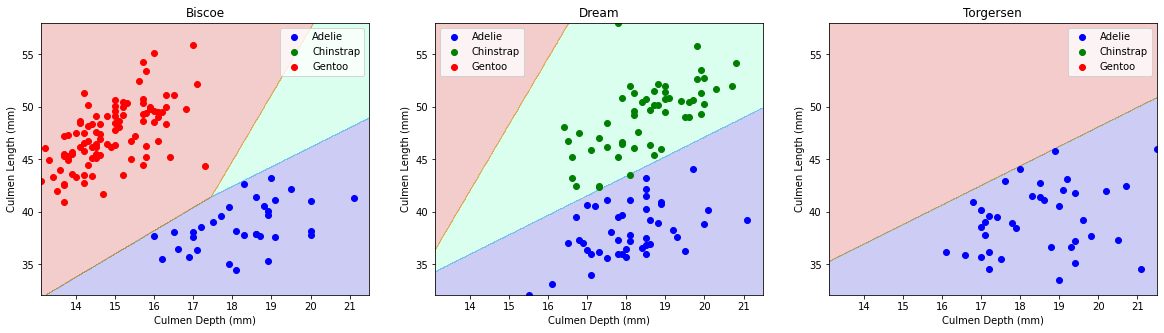

In [18]:
plot_regions(LR, X_trainLR, y_trainLR, ax_num, "Culmen Depth (mm)","Culmen Length (mm)")

#### 4.  Discussion for multinomial logistic regression

The model was able to predict the penguin species with extreme accuracy, only mislabeling one of the data points and scoring 0.984 on the test data. 

The confusion matrix seems to indicate that the error happened on the second island (Dream), and looking at the decision regions on the second graph above we can see that the blue and green points (Adelie and Chinstrap penguins, respectively) are very close to each other. Comparing the blue points across all three decision region graphs, we can see that the Culmen Lengths and Depths for Adelie penguins are very similar to those of Chinstrap penguins, and they have some points of potential overlap. 

This overlap is most likely what led the model to incorrectly label one of the Chinstrap points as Adelie. Chinstrap and Adelie penguins can have Culmen Lengths and Depths in the same ranges, so mislabeling only one of these points is still impressive. 

<br>

## 5. Discussion

Overall, all three of our models performed well, with scores of 0.983, 0.952, and 0.919 for multinomial logistic regression, random forests, and K nearest neighbors, respectively. The highest accuracy score was seen in the logistic regression model that used Island, Culmen Length, and Culmen Depth, so we recommend those as the ideal model and features for predicting penguin species. 

Increasing the number of samples in the data would reduce the effect that outliers have on the data and lead to a more reliable prediction overall. It would also allow us to see if our logistic regression model really does predict species with a 98% accuracy rate and make sure that it was not due to a small sample size. 

More data on Gentoo and Chinstrap penguins would also be helpful, since the majority of the current data set is Adelie penguins. They could also expand to more diverse islands, since Torgersen Island only housed Adelie penguins and not Gentoos or Chinstraps. 